In [1]:
# Uncomment line below if LOAD_PATH returns only 2
push!(LOAD_PATH,"/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers");
# Uncomment line below if PyPlot isn't installed in you v0.6.0 .julia environment 
#   This system assumes usage of Python2.7 in your .julia environment
# Pkg.add("PyPlot")
# LOAD_PATH

In [2]:
# Push local directory to get access to GradientModels
push!(LOAD_PATH,pwd());

In [3]:
LOAD_PATH

4-element Array{Any,1}:
 "/Applications/Julia-0.6.app/Contents/Resources/julia/local/share/julia/site/v0.6"
 "/Applications/Julia-0.6.app/Contents/Resources/julia/share/julia/site/v0.6"      
 "/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers"                              
 "/Users/ilanfilonenko/sgd-vr-precision/experiments"                               

In [4]:
# Update packages
# Pkg.update();

In [5]:
using PyPlot

In [6]:
using GradientModels

In [7]:
using FixedPointNumbers

In [8]:
# generate low-precision logistic regression problem
d = 100;
N = 1000;
wgenerator = 0.03 * randn(d);
X = map(Float64, rand(Int8, N, d));
Yprobs = 1 ./ (1 + exp.(-X * wgenerator))
Y = (Yprobs .>= rand(N)) * 2 - 1;
gamma_reg = 100.0;

In [9]:
function logreg_loss(w, X, Y)
    return sum(log(1 + exp.(-Y .* (X * w)))) / length(Y) + gamma_reg * norm(w)^2 / 2;
end

function logreg_grad(w, X, Y)
    return -X' * (Y ./ (1 + exp.(Y .* (X * w)))) / length(Y) + gamma_reg * w;
end

function logreg_hess(w, X, Y)
    return X' * ((1 ./ ((1 + exp.(Y .* (X * w))) .* (1 + exp.(-Y .* (X * w))))) .* X) / length(Y) + gamma_reg * eye(length(w));
end
function sgd_logreg(w0, alpha, X, Y, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        i = rand(1:N)
        xi = X[i,:]';
        yi = Y[i];
        w = w - alpha * logreg_grad(w, xi, yi);
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

function quantize_scalar(w, b, s)
    qmax = s * (2^(b-1) - 1);
    qmin = -s * (2^(b-1));
    if (w <= qmin)
        return qmin;
    elseif (w >= qmax)
        return qmax;
    else
        return floor((w / s) + rand()) * s
    end
end

function quantize(w, b, s)
    return map(z -> quantize_scalar(z, b, s), w);
end

quantize (generic function with 1 method)

In [10]:
# newton's method
function newton_logreg(w0, X, Y, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = logreg_grad(w, X, Y)
        H = logreg_hess(w, X, Y);
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end

newton_logreg (generic function with 1 method)

In [11]:
wopt = newton_logreg(zeros(d), X, Y, 20);

gradient norm: 31.999954355436195
gradient norm: 8.534479512457136
gradient norm: 2.3290829496882863
gradient norm: 0.29344583668295127
gradient norm: 0.005900753178225471
gradient norm: 2.5370963908339828e-6
gradient norm: 4.744179487848581e-13
gradient norm: 4.441765981113912e-15
gradient norm: 3.2522641806751168e-15
gradient norm: 3.2540537643969105e-15
gradient norm: 3.010113399609906e-15
gradient norm: 3.467474552802781e-15
gradient norm: 3.3599727529141488e-15
gradient norm: 3.2060691198968787e-15
gradient norm: 3.1499831876930037e-15
gradient norm: 3.271608682958075e-15
gradient norm: 3.1326670929122045e-15
gradient norm: 2.8156423067120543e-15
gradient norm: 3.599670446790696e-15


In [12]:
# Gradient for Logistic Regression
g_log_loss = ((w, X, Y) -> -X' * (Y ./ (1 + exp(Y .* (X * w)))) / length(Y) + gamma_reg * w)
# Gradient for Logistic Regression
lmhalp_g_log_loss = ((p, Y) -> (-Y ./ (1 + exp.(Y .* p))) / length(Y))

(::#17) (generic function with 1 method)

In [13]:
scale_max = maximum(abs.(wopt)) * 2.0;
lp_b8 = 8;
lp_s8 = scale_max * 2.0^(-7);
lp_b16 = 16;
lp_s16 = scale_max * 2.0^(-15);
lp_b32 = 32;
lp_s32 = scale_max * 2.0^(-31);

In [14]:
S32 = Scaled{Int32,31,lp_s32,SatAndRandomized};
S16 = Scaled{Int16,15,lp_s16,SatAndRandomized};
S8 = Scaled{Int8,7,lp_s8,SatAndRandomized};

In [15]:
w0 = randn(d);
w02 = quantize(w0, lp_b8, lp_s8);
w03 = float(S8(w0));

In [16]:
function lp_svrg_logreg(w0, alpha, X, Y, b, s, niters, nepochs, wopt)
    w = quantize(w0, b, s)
    (N, d) = size(X)
    dist_to_optimum = zeros(niters * nepochs)
    for iepoch = 1:nepochs
        wtilde = w;
        gtilde = logreg_grad(wtilde, X, Y);
        for k = 1:niters
            i = rand(1:N)
            xi = X[i,:]';
            yi = Y[i];
            w = w - alpha * (logreg_grad(w, xi, yi) - logreg_grad(wtilde, xi, yi) + gtilde);
            w = quantize(w, b, s);
            dist_to_optimum[k + ((iepoch - 1) * niters)] = norm(w - wopt);
        end
    end
    return (w, dist_to_optimum);
end

lp_svrg_logreg (generic function with 1 method)

In [17]:
blue = 8;
purple = 8;
alpha = 0.0000005;
mu = 1000.0;
tol = 1.0;
epoch_length = N * 10;
num_epochs = 15;

In [35]:
(w,dto_svrg) = SVRG{alpha,N*10,15}(w0,wopt,X,Y,logreg_grad);
(w,dto_lpsvrg8) = LPSVRG{alpha,N*10,15,S8}(w0,wopt,X,Y,logreg_grad);
(w,dto_lpsvrg16) = LPSVRG{alpha,N*10,15,S16}(w0,wopt,X,Y,logreg_grad);
(w,dto_halp8) = HALP{alpha,N*10,15,S8}(w0,wopt,X,Y,mu,logreg_grad);
(w,dto_halp16) = HALP{alpha,N*10,15,S16}(w0,wopt,X,Y,mu,logreg_grad);


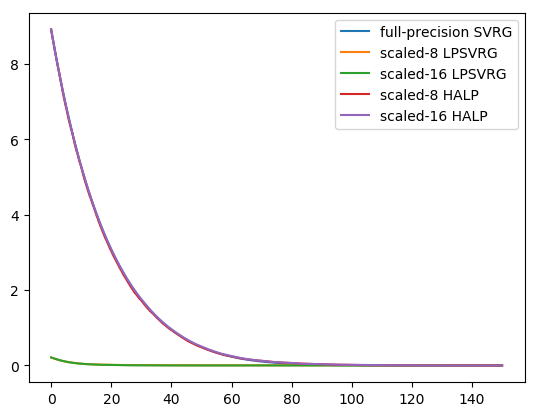

PyObject <matplotlib.legend.Legend object at 0x10dac7110>

In [36]:
xs = collect(1:length(dto_svrg)) / 1000.0;
plot(xs,dto_svrg;label="full-precision SVRG")
plot(xs,dto_lpsvrg8;label="scaled-8 LPSVRG")
plot(xs,dto_lpsvrg16;label="scaled-16 LPSVRG")
plot(xs,dto_halp8;label="scaled-8 HALP")
plot(xs,dto_halp16;label="scaled-16 HALP")
legend()

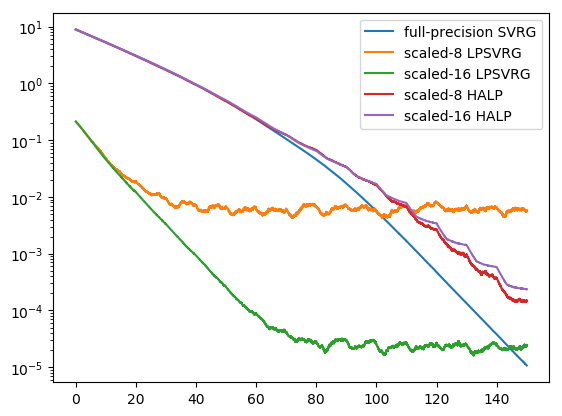

PyObject <matplotlib.legend.Legend object at 0x10d8d7ed0>

In [37]:
semilogy(xs,dto_svrg;label="full-precision SVRG")
semilogy(xs,dto_lpsvrg8;label="scaled-8 LPSVRG")
semilogy(xs,dto_lpsvrg16;label="scaled-16 LPSVRG")
semilogy(xs,dto_halp8;label="scaled-8 HALP")
semilogy(xs,dto_halp16;label="scaled-16 HALP")
legend()

In [21]:
# Gradient for Logistic Regression
halp_g_log_loss = ((p, Y) -> (-Y ./ (1 + exp.(Y .* p))) / length(Y))

(::#21) (generic function with 1 method)

In [28]:
(w,dto_halp8) = HALP{alpha,epoch_length,num_epochs,S8}(w0,wopt,X,Y,mu,logreg_grad);

In [23]:
(w,dto_lmhalp8) = LMHALP{alpha,epoch_length,num_epochs,S8}(w0,wopt,X,Y,blue,purple,mu,tol,gamma_reg,halp_g_log_loss);

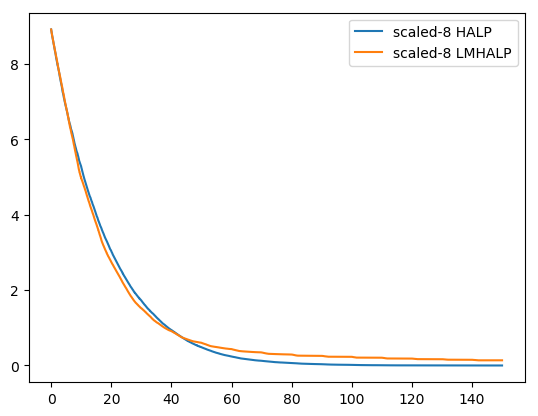

PyObject <matplotlib.legend.Legend object at 0x1441ebf10>

In [38]:
xs = collect(1:length(dto_svrg)) / 1000.0;
plot(xs,dto_halp8;label="scaled-8 HALP")
plot(xs,dto_lmhalp8;label="scaled-8 LMHALP")
legend()

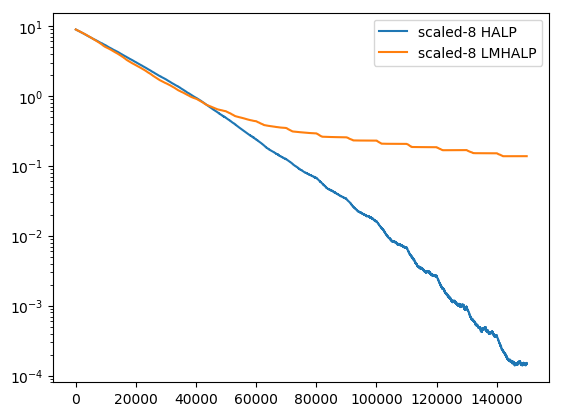

PyObject <matplotlib.legend.Legend object at 0x1271049d0>

In [39]:
semilogy(dto_halp8;label="scaled-8 HALP")
semilogy(dto_lmhalp8;label="scaled-8 LMHALP")
legend()